# Predicting Apartment Prices in Mexico City


In [2]:
# Import libraries here
import warnings
from glob import glob
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

# Prepare Data

In [3]:
# Build your `wrangle` function
def wrangle(filepath):
    df=pd.read_csv(filepath)
     # Subset data: Apartments in "Capital Federal", less than 100,000
    mask_ba = df["place_with_parent_names"].str.contains("Distrito Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 100_000
    df = df[mask_ba & mask_apt & mask_price]
    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]
    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)
    # Get place name
    df["borough"] = df["place_with_parent_names"].str.split("|", expand=True)[1]
    df.drop(columns="place_with_parent_names", inplace=True)
    # drop null value columns
    df.drop(columns=['surface_total_in_m2','price_usd_per_m2','floor','rooms','expenses'],inplace=True)
    # drop low and high cardinality columns
    df.drop(columns=['operation','property_type','currency','properati_url'],inplace=True)
    #drop leaky columns
    df.drop(columns=['price','price_aprox_local_currency','price_per_m2'],inplace=True)

    
    return df

In [4]:
# Use this cell to test your wrangle function and explore the data
df=wrangle('data/mexico-city-real-estate-1.csv')
df.head()

,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
11,94022.66,57.0,23.634501,-102.552788,Benito Juárez
20,70880.12,56.0,19.402413,-99.095391,Iztacalco
21,68228.99,80.0,19.357820,-99.149406,Benito Juárez
22,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
26,94140.20,50.0,19.354219,-99.126244,Coyoacán


Use glob to create the list `files`. It should contain the filenames of all the Mexico City real estate CSVs in the `./data` directory, except for `mexico-city-test-features.csv`.

In [5]:
files= glob('data/mexico-city-real-estate-*.csv')
files[:5]

['data\\mexico-city-real-estate-1.csv',
 'data\\mexico-city-real-estate-2.csv',
 'data\\mexico-city-real-estate-3.csv',
 'data\\mexico-city-real-estate-4.csv',
 'data\\mexico-city-real-estate-5.csv']

In [6]:
frames=[wrangle(file) for file in files]
df = pd.concat(frames,ignore_index=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5473 entries, 0 to 5472
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        5473 non-null   float64
 1   surface_covered_in_m2  5473 non-null   float64
 2   lat                    5149 non-null   float64
 3   lon                    5149 non-null   float64
 4   borough                5473 non-null   object 
dtypes: float64(4), object(1)
memory usage: 213.9+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
0,94022.66,57.0,23.634501,-102.552788,Benito Juárez
1,70880.12,56.0,19.402413,-99.095391,Iztacalco
2,68228.99,80.0,19.357820,-99.149406,Benito Juárez
3,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
4,94140.20,50.0,19.354219,-99.126244,Coyoacán


# Explore Data

Create a histogram showing the distribution of apartment prices (`"price_aprox_usd"`) in `df`. Be sure to label the x-axis `"Area [sq meters]"`, the y-axis `"Count"`, and give it the title `"Distribution of Apartment Prices"`.


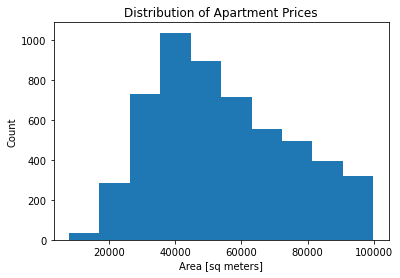

In [7]:
# Plot distribution of price
plt.hist(df['price_aprox_usd'])
plt.xlabel('Area [sq meters]')
plt.ylabel('Count')
plt.title('Distribution of Apartment Prices')
plt.show()

reate a scatter plot that shows apartment price (`"price_aprox_usd"`) as a function of apartment size (`"surface_covered_in_m2"`). Be sure to label your axes `"Price [USD]"` and `"Area [sq meters]"`, respectively. Your plot should have the title `"Mexico City: Price vs. Area"`.

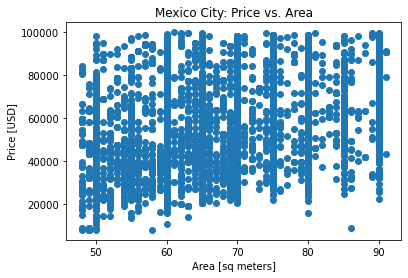

In [8]:
# Plot price vs area
plt.scatter(df['surface_covered_in_m2'],df['price_aprox_usd'])
plt.xlabel('Area [sq meters]')
plt.ylabel('Price [USD]')
plt.title('Mexico City: Price vs. Area')
plt.show()

# Split Data

In [9]:
# Split data into feature matrix `X_train` and target vector `y_train`.

X_train = df.drop(columns=['price_aprox_usd'])
y_train = df['price_aprox_usd']

# Build Model

## Baseline

In [10]:
#Calculate the baseline mean absolute error for your model
y_mean = y_train.mean()
y_pred_baseline = [y_mean]*len(y_train)
baseline_mae = mean_absolute_error(y_train,y_pred_baseline)
print("Mean apt price:", y_mean)
print("Baseline MAE:", baseline_mae)

Mean apt price: 54246.53149826422
Baseline MAE: 17239.939475888295


## Iterate


Create a pipeline named `model` that contains all the transformers necessary for this dataset and one of the predictors you've used during this project. Then fit your model to the training data.

In [11]:
# Build Model
model = make_pipeline(
    OneHotEncoder(use_cat_names=True)
    ,SimpleImputer()
    ,Ridge())
# Fit model
model.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['borough'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

## Evaluate

In [22]:
X_test = pd.read_csv('data/mexico-city-test-features.csv',sep = "\t", encoding='latin')
print(X_test.info())
X_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041 entries, 0 to 1040
Data columns (total 1 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   surface_covered_in_m2,lat,lon,borough  1041 non-null   object
dtypes: object(1)
memory usage: 8.3+ KB
None


,"surface_covered_in_m2,lat,lon,borough"
0,"60,19.493185,-99.205755,Azcapotzalco"
1,"55,19.307247,-99.1667,Coyoacán"
2,"50,19.363469,-99.010141,Iztapalapa"
3,"60,19.474655,-99.189277,Azcapotzalco"
4,"74,19.394628,-99.143842,Benito Juárez"
